In [4]:
#| default_exp tfsm/voxt

we will look into transforms like 
- RandomCrop keeping foreground objects 
- padding 
- randomflip 
- random erase 
- cutmix 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#| export 
import numpy as np
import fastcore.all as fc
from typing import Union, Tuple, List
from voxdet.tfsm.standard import BaseT
from voxdet.tfsm.utils import corner_2_chwd, chwd_2_corner
from voxdet.bbox_func.bbox_iou import calculate_iou
import math
from loguru import logger

In [4]:
from PIL import Image
from voxdet.utils import vis, image_grid, thumbnail

## Normalize 

In [5]:
#| export 
class Norm3d(BaseT):
    def __init__(self, a_min:float, a_max:float, b_min:float=None, b_max:float=None, clip:bool=True, renorm:bool=False): 
        super().__init__()
        fc.store_attr()
    __repr__ = fc.basic_repr(flds="a_min, a_max, b_min, b_max, clip")
    
    def apply(self, img:dict):
        assert "images" in img.keys(), "images key is not present"
        fimg = img["images"]
        nimg = {}
        nimg["images"] = self.apply_image(fimg)
        for i in img.keys(): 
            if i not in nimg.keys(): nimg[i] = img[i]
        return nimg 
    
    def apply_image(self, img):
        if self.a_max - self.a_min == 0.0: 
            logger.warning("Divide by zero (a_min == a_max)")
            if self.b_min is None: return img - self.a_min
            return img - self.a_min + self.b_min 
        img = (img - self.a_min) / (self.a_max - self.a_min)
        if (self.b_min is not None) and (self.b_max is not None):
            img = img * (self.b_max - self.b_min) + self.b_min
        if self.clip:
            img = np.clip(img, self.b_min, self.b_max)
        if self.renorm:
            img = 2*img - 1 # renormalize the image from [-1, 1]
        return img.astype(np.float32)
    
    def reverse_apply(self, img: dict): return img

In [6]:
scan = np.ones((10, 10, 10))*2018
norm = Norm3d(a_min = -1024.0,
      a_max = 300.0,
      b_min = 0.0,
      b_max = 1.0,
      clip = True)
out = norm({"images": scan})
assert out["images"].max() == 1, "something is wrong with Norm3d"

In [7]:
scan = np.random.beta(5, 2, (10, 10, 10))
norm = Norm3d(a_min = -1024.0,
      a_max = 300.0,
      b_min = 0.0,
      b_max = 1.0,
      clip = True,
      renorm = True)
out = norm({"images": scan})
assert out["images"].max() <= 1, "something is wrong with Norm3d"
assert out["images"].min() >= -1, "something is wrong with Norm3d"

In [8]:
scan4d = np.ones((2, 10, 10, 10))*2018
norm = Norm3d(a_min = -1024.0,
      a_max = 300.0,
      b_min = 0.0,
      b_max = 1.0,
      clip = True)
out4d = norm({"images": scan4d})
assert out4d["images"].max() == 1, "something is wrong with Norm3d"

In [9]:
out["images"].dtype

dtype('float32')

## Padding 

In [10]:
img = np.zeros((96+32, 192+96, 192+96)) #zyx
bbox = np.asarray([[10, 10, 10, 20, 20, 20], [80, 80, 80, 120, 120, 90]])

In [11]:
pad = 10
pad = (pad,)*3 if isinstance(pad, int) else pad
pimg = np.zeros(np.asarray(img.shape) + 2*np.asarray(pad))
pimg[pad[0]:-pad[0], pad[1]:-pad[1], pad[2]:-pad[2]] = img
pimg.shape, img.shape

((148, 308, 308), (128, 288, 288))

In [12]:
bbox + np.asarray(pad+pad)

array([[ 20,  20,  20,  30,  30,  30],
       [ 90,  90,  90, 130, 130, 100]])

In [13]:
#| export 
def pad3d(img: np.ndarray, bbox: np.ndarray, pad:Union[int, Tuple[int]], side="both"):
    """img is [zyxzyx], bbox[zyx] pad[zyx]
    Pads the image in all direction. we usually gets twice the size of the asked padding.
    side takes "left" "right" "both" values
    """
    if side not in ["left", "right", "both"]: raise NotImplementedError(f"side cannot be {side}")
    
    pad = (pad,)*3 if isinstance(pad, int) else pad
    n = 2 if side == "both" else 1
    
    multi_view = len(img.shape) == 4
    img_shape = img.shape[1:] if multi_view else img.shape
    pimg = np.zeros(np.asarray(img_shape) + n*np.asarray(pad))
    if multi_view:
        pimg = np.expand_dims(pimg, axis=0)
        pimg = np.repeat(pimg, img.shape[0], axis=0)
    
    if side == "right": pad = (0, 0, 0)
    ims = np.asarray(img_shape) + np.asarray(pad)
    if multi_view:
        pimg[:, pad[0]:ims[0], pad[1]:ims[1], pad[2]:ims[2]] = img
    else:
        pimg[pad[0]:ims[0], pad[1]:ims[1], pad[2]:ims[2]] = img
    
    if bbox is None: return pimg 
    pbbox = bbox + np.asarray(tuple(pad)+tuple(pad))
    return pimg, pbbox

In [14]:
img = np.ones((10, 10, 10))
bbox = np.asarray([[1, 1, 2, 2, 4, 4], [3, 3, 4, 4, 5, 5]])
pad = 2 
pimg, pbbox = pad3d(img, bbox, pad)
fc.all_equal(pimg.shape, (14, 14, 14))
fc.all_equal(bbox+2, pbbox)

True

In [15]:
img2 = np.ones((2, 10, 10, 10))
bbox = np.asarray([[1, 1, 2, 2, 4, 4], [3, 3, 4, 4, 5, 5]])
pad = 2 
pimg2, pbbox = pad3d(img2, bbox, pad)
fc.all_equal(pimg2.shape, (2, 14, 14, 14))
fc.all_equal(bbox+2, pbbox)

True

In [16]:
image_grid([Image.fromarray(i*255) for i in img], 2, 5)

In [17]:
image_grid([Image.fromarray(i*255) for i in pimg], 2, 7)

### Pad left

In [18]:
pimg, pbbox = pad3d(img, bbox, pad, side="left")
fc.all_equal(pimg.shape, (12, 12, 12))
fc.all_equal(bbox+2, pbbox)

True

In [19]:
image_grid([Image.fromarray(i*255) for i in pimg], 2, 6)

### Pad right

In [20]:
pimg, pbbox = pad3d(img, bbox, pad, side="right")
fc.all_equal(pimg.shape, (12, 12, 12))
fc.all_equal(bbox, pbbox)

True

In [21]:
image_grid([Image.fromarray(i*255) for i in pimg], 2, 6)

### Pad using Rsize 

In [22]:
img = np.ones((10, 10, 10))
rsize = (13, 14, 12)

In [23]:
pad_shape = np.maximum(np.asarray(rsize) - np.asarray(img.shape), 0)
both_pad = np.floor(pad_shape/2)
right_pad = pad_shape%2
right_pad, both_pad

(array([1, 0, 0]), array([1., 2., 1.]))

In [24]:
fc.all_equal(right_pad+2*both_pad+img.shape, rsize)

True

In [25]:
#| export
def pad3d_by_rsize(img: np.ndarray, bbox: np.ndarray, rsize: Tuple[int], side="symmetric"):
    """img is [zyxzyx], bbox[zyx] crop[zyx]"""
    img_shape = img.shape[1:] if len(img.shape) == 4 else img.shape
    pad_shape = np.maximum(np.asarray(rsize) - np.asarray(img_shape), 0)
    if side != "symmetric": return pad3d(img, bbox, pad_shape.astype(int), side=side)
    both_pad = np.floor(pad_shape/2).astype(int)
    right_pad = pad_shape%2
    if bbox is None:
        bimg = pad3d(img, None, both_pad, side="both")
        rimg = pad3d(bimg, None, right_pad, side="right")
        return rimg
    bimg, bbbox = pad3d(img, bbox, both_pad, side="both")
    rimg, rbbox = pad3d(bimg, bbbox, right_pad, side="right")
    return rimg, rbbox

In [26]:
img = np.ones((10, 10, 10))
rsize = (15, 14, 12)
rimg = pad3d_by_rsize(img, None, rsize)
fc.all_equal(rimg.shape, rsize)

True

In [27]:
img2 = np.ones((2, 10, 10, 10))
rsize = (15, 14, 12)
rimg2 = pad3d_by_rsize(img2, None, rsize)
fc.all_equal(rimg2.shape[1:], rsize)

True

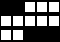

In [28]:
image_grid([Image.fromarray(i*255) for i in rimg], 3, 5)

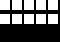

In [29]:
rimg = pad3d_by_rsize(img, None, rsize, side="right")
image_grid([Image.fromarray(i*255) for i in rimg], 3, 5)

In [30]:
fc.all_equal(pad3d_by_rsize(img, None, (21, 42, 12)).shape, (21, 42, 12))
fc.all_equal(pad3d_by_rsize(img, None, (8, 7, 6)).shape, (10, 10, 10))
fc.all_equal(pad3d_by_rsize(img, None, (12, 12, 6)).shape, (12, 12, 10))
fc.all_equal(pad3d_by_rsize(img, None, (12, 6, 6)).shape, (12, 10, 10))
fc.all_equal(pad3d_by_rsize(img, None, (14, 18, 17)).shape, (14, 18, 17))

True

In [31]:
fc.all_equal(pad3d_by_rsize(img2, None, (21, 42, 12)).shape[1:], (21, 42, 12))
fc.all_equal(pad3d_by_rsize(img2, None, (8, 7, 6)).shape[1:], (10, 10, 10))
fc.all_equal(pad3d_by_rsize(img2, None, (12, 12, 6)).shape[1:], (12, 12, 10))
fc.all_equal(pad3d_by_rsize(img2, None, (12, 6, 6)).shape[1:], (12, 10, 10))
fc.all_equal(pad3d_by_rsize(img2, None, (14, 18, 17)).shape[1:], (14, 18, 17))

True

In [32]:
def test_bbox(rsize) -> None:
    bbox = np.asarray([[1, 2, 3, 4, 5, 6]])
    b = bbox[0]
    img = np.ones((10, 10, 10))
    img2 = np.ones((2, 10, 10, 10))
    
    img[b[0]: b[3], b[1]:b[4], b[2]:b[5]] = 5
    img2[:, b[0]: b[3], b[1]:b[4], b[2]:b[5]] = 5

    pimg, pbbox = pad3d_by_rsize(img, bbox, rsize)
    pimg2, pbbox = pad3d_by_rsize(img2, bbox, rsize)

    pb = pbbox[0]

    fc.all_equal(img[b[0]: b[3], b[1]:b[4], b[2]:b[5]], pimg[pb[0]: pb[3], pb[1]:pb[4], pb[2]:pb[5]])
    fc.all_equal(img2[:, b[0]: b[3], b[1]:b[4], b[2]:b[5]], pimg2[:, pb[0]: pb[3], pb[1]:pb[4], pb[2]:pb[5]])

test_bbox((21, 42, 12))
test_bbox((8, 7, 6))
test_bbox((12, 12, 6))
test_bbox((12, 6, 6))
test_bbox((14, 18, 17))

### Pad by a divisible 

In [33]:
sd = 512
img_shape = (np.random.randint(96), np.random.randint(192), np.random.randint(192))
new_shape = np.ceil(np.asarray(img_shape)/sd)*sd
pad_size = np.maximum(np.asarray(new_shape) - np.asarray(img_shape), 0)
img_shape, new_shape, pad_size

((85, 65, 58), array([512., 512., 512.]), array([427., 447., 454.]))

In [34]:
#| export 
def pad3d_by_div(img: np.ndarray, bbox: np.ndarray, size_divisible: int=4, side: str= "symmetric"):
    """img is [zyxzyx], bbox[zyx] set the final img dim should be divisible by {size_divisible}"""
    img_shape = img.shape[1:] if len(img.shape) == 4 else img.shape
    new_shape = (np.ceil(np.asarray(img_shape)/size_divisible)*size_divisible).astype(int)
    return pad3d_by_rsize(img, bbox, new_shape, side)

In [35]:
img = np.ones((11, 11, 11))
bbox = np.asarray([[1, 1, 1, 1, 1, 1]])
img, bbox = pad3d_by_div(img, bbox, size_divisible=32)
img.shape, bbox

((32, 32, 32), array([[11, 11, 11, 11, 11, 11]]))

In [36]:
img2 = np.ones((2, 11, 11, 11))
bbox = np.asarray([[1, 1, 1, 1, 1, 1]])
img2, bbox = pad3d_by_div(img2, bbox, size_divisible=32)
img2.shape, bbox

((2, 32, 32, 32), array([[11, 11, 11, 11, 11, 11]]))

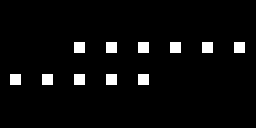

In [37]:
image_grid([Image.fromarray(i*255) for i in img], 4, 8)

## PadIfNeeded Function

In [38]:
#| export 
class PadIfNeeded(BaseT):
    def __init__(self, sd=None, img_size=None, side: str="right"):
        """sd is size divisible, img_size in zyx format. One of it should be None"""
        fc.store_attr()
        super().__init__()
        assert self.side in ["right"], "only right side is implemented"
        if (self.sd is None) and (self.img_size is None): raise ValueError("Both intputs sd and img_size cant be None")
        if None not in (self.sd, self.img_size): raise ValueError("One of sd or img_size should be None. Both are given")
    
    __repr__ = fc.basic_repr("sd, img_size, side")
    
    def apply(self, img: dict):
        assert "images" in img.keys(), f"images not present in input [img]. Only: {img.keys()} present"
        fimg = img["images"].copy()
        bbox = img["boxes"].copy() if "boxes" in img.keys() else None
        nimg = {}
        out = pad3d_by_div(fimg, bbox, self.sd, self.side) if self.sd is not None else pad3d_by_rsize(fimg, bbox, self.img_size, self.side)
        if bbox is None: nimg["images"] = out
        else: nimg["images"], nimg["boxes"] = out
        for i in img.keys():
            if i not in nimg.keys(): nimg[i] = img[i]
        return nimg
    
    def reverse_apply(self, img: dict): 
        if self.side != "right": raise ValueError("only right allowed")
        return img 

In [39]:
fc.test_fail(PadIfNeeded, kwargs=dict(sd=None, img_size=None))
fc.test_fail(PadIfNeeded, kwargs=dict(sd=32, img_size=(100, 100)))
fc.test_fail(PadIfNeeded, kwargs=dict(sd=32, side="asymetric"))

In [40]:
pin = PadIfNeeded(sd=32)
pin

__main__.PadIfNeeded(sd=32, img_size=None, side='right')

In [41]:
img = {}
img["images"] = np.ones((12, 13, 14))
img["boxes"] = np.empty((0, 6))

In [42]:
nimg = pin(img)
nimg["images"].shape, img["images"].shape, nimg["boxes"], img["boxes"]

((32, 32, 32),
 (12, 13, 14),
 array([], shape=(0, 6), dtype=float64),
 array([], shape=(0, 6), dtype=float64))

In [43]:
img = {}
img["images"] = np.ones((12, 13, 14))
img["boxes"] = np.asarray([[2, 6, 3, 1, 4, 8]])

In [44]:
nimg = pin(img)
nimg["images"].shape, img["images"].shape, nimg["boxes"], img["boxes"]

((32, 32, 32),
 (12, 13, 14),
 array([[2, 6, 3, 1, 4, 8]]),
 array([[2, 6, 3, 1, 4, 8]]))

In [45]:
img2 = {}
img2["images"] = np.ones((2, 42, 33, 14))
img2["boxes"] = np.asarray([[2, 6, 3, 1, 4, 8]])

In [46]:
nimg2 = pin(img2)
nimg2["images"].shape, img2["images"].shape, nimg2["boxes"], img2["boxes"]

((2, 64, 64, 32),
 (2, 42, 33, 14),
 array([[2, 6, 3, 1, 4, 8]]),
 array([[2, 6, 3, 1, 4, 8]]))

## Transpose

```
xyz -> (1, 2, 0) -> yzx -> (2, 0, 1) -> xyz
xyz -> (1, 0, 2) -> yxz -> (1, 0, 2) -> xyz
xyz -> (2, 1, 0) -> zyx -> (2, 1, 0) -> xyz
xyz -> (2, 0, 1) -> zxy -> (1, 2, 0) -> xyz
xyz -> (0, 2, 1) -> xzy -> (0, 2, 1) -> xyz
xyz -> (0, 1, 2) -> xyz -> (0, 1, 2) -> xyz
```
xyz -> (1, 2, 0) -> yzx -> (2, 0, 1) -> xyz
xyz -> (2, 0, 1) -> zxy -> (1, 2, 0) -> xyz

xyz -> (1, 0, 2) -> yxz -> (1, 0, 2) -> xyz
xyz -> (2, 1, 0) -> zyx -> (2, 1, 0) -> xyz


```
xyzxyz -> (1, 2, 0, 4, 5, 3) -> yzxyzx -> (2, 0, 1, 5, 3, 4) -> xyz
xyz -> (1, 0, 2) -> yxz -> (1, 0, 2) -> xyz
xyz -> (2, 1, 0) -> zyx -> (2, 1, 0) -> xyz
xyz -> (2, 0, 1) -> zxy -> (1, 2, 0) -> xyz
xyz -> (0, 2, 1) -> xzy -> (0, 2, 1) -> xyz
xyz -> (0, 1, 2) -> xyz -> (0, 1, 2) -> xyz

In [47]:
#| export
class Transpose(BaseT):
    def __init__(self, order: tuple= None):
        fc.store_attr()
        super().__init__()
        assert len(order) ==3, f"only order 3 is allowed for now. given: {self.order}"
        self.rorder = self.reverse_order()
        self.boxo = self.order + tuple([i+len(self.order) for i in self.order])
        self.boxro = self.rorder + tuple([i+len(self.rorder) for i in self.rorder])
    
    __repr__ = fc.basic_repr(flds="order")
    
    def apply(self,  img):
        if self.order is None: return img
        assert "images" in img.keys(), "images key not Present"
        fimg = img["images"].copy()
        assert len(self.order) == len(fimg.shape), f"order: {self.order} and img : {fimg.shape} is not same"
        nimg={}
        nimg["images"] = self.apply_img(fimg, self.order)
        if "boxes" in img.keys(): nimg["boxes"] = self.apply_bbox(img["boxes"], self.boxo)
        if "spacing" in img.keys(): nimg["spacing"] = [img['spacing'][i] for i in self.order]
        for i in img.keys():
            if i not in nimg.keys(): nimg[i] = img[i]
        return nimg
    
    def apply_img(self, img, order): return img.transpose(order)

    def apply_bbox(self, bbox, order):
        out = bbox.copy()
        out = out[:, order]
        return out 
    
    def reverse_apply(self, img: dict):
        assert "images" in img.keys()
        nimg = {}
        nimg["images"] = self.apply_img(img["images"], self.rorder)
        if "boxes" in img.keys(): nimg["boxes"] = self.apply_bbox(img["boxes"], self.boxro)
        if "spacing" in img.keys(): nimg["spacing"] = [img['spacing'][i] for i in self.rorder]
        for i in img.keys():
            if i not in nimg.keys(): nimg[i] = img[i]
        return nimg
    
    def reverse_order(self):
        o = "".join(map(lambda x: str(x), self.order))
        mapper = {"120": "201", "102": "102", "210": "210", "201": "120", "021": "021", "012": "012"}
        return tuple([int(i) for i in mapper[o]])

In [48]:
tr = Transpose(order=(1, 2, 0))
tr

__main__.Transpose(order=(1, 2, 0))

In [49]:
img = {}
img["images"] = np.ones((12, 13, 14))
img["boxes"] = np.empty((0, 6))
trimg = tr(img)
print(img["boxes"], img["images"].shape, trimg["boxes"], trimg["images"].shape)

[] (12, 13, 14) [] (13, 14, 12)


In [50]:
tr.order, tr.rorder

((1, 2, 0), (2, 0, 1))

In [51]:
trimg = tr(img)
print(img["boxes"], img["images"].shape, trimg["boxes"], trimg["images"].shape)

[] (12, 13, 14) [] (13, 14, 12)


In [52]:
rr = tr.reverse_apply(trimg)
rr["images"].shape, rr["boxes"]

((12, 13, 14), array([], shape=(0, 6), dtype=float64))

## RandomCrop 

In [53]:
img = np.zeros((331, 400, 400)) #zyx
#bbox = np.asarray([[ 91   , 238 ,  83, 100   , 250 , 91], [80, 80, 80, 90, 120, 120]]) #xyz
bbox = np.asarray([[330, 238, 83, 331, 250, 91], [80, 80, 80, 90, 120, 120]])
bbox2 = np.empty((0, 6))
for b in bbox:
    img[int(b[0]): int(b[3]), int(b[1]):int(b[4]), int(b[2]): int(b[5])] = 1
img.sum(), img.shape, bbox

(16096.0,
 (331, 400, 400),
 array([[330, 238,  83, 331, 250,  91],
        [ 80,  80,  80,  90, 120, 120]]))

### steps and issues involved
- No bbox 
- image_size is smaller than what is required. 


### Algo:
- select a crop size (96, 192, 192) in this case
- select a box and find its center: create a grid 
- select one point as center and crop the image from that space. 
- realign bboxes to this new crop 

In [54]:
crop_size = (96, 192, 192)
b1 = bbox[np.random.randint(len(bbox))].reshape(1, -1)
b1

array([[ 80,  80,  80,  90, 120, 120]])

In [55]:
(b1[:, 3:] - b1[:, :3])/2
# out[:, 3:] = hwd
# out[:, :3] = bbox[:, :3]+hwd

array([[ 5., 20., 20.]])

In [56]:
b1c = corner_2_chwd(b1)[0]
b1c

array([ 85., 100., 100.,  10.,  40.,  40.])

> Get all the centers keeping bbox center as centr and crop_size as size

In [57]:
x = b1c[:3]- np.asarray(crop_size)/2
y = b1c[:3]+ np.asarray(crop_size)/2
x, y, b1c

(array([37.,  4.,  4.]),
 array([133., 196., 196.]),
 array([ 85., 100., 100.,  10.,  40.,  40.]))

In [58]:
# Remove all centers which are outside image 
x = np.maximum(x, 0)
y = np.minimum(y, img.shape)
x, y

(array([37.,  4.,  4.]), array([133., 196., 196.]))

In [59]:
# we need to select boxes which are inside image 
x = np.maximum(x, np.asarray(crop_size)/2)#.astype(int)
y = np.minimum(y, np.asarray(img.shape) - np.asarray(crop_size)/2)#.astype(int)
x, y

(array([48., 96., 96.]), array([133., 196., 196.]))

previously we did this but the problem is that when x is 282.5 , we floor it 282 and this takes the bounding box away from image.
```
x = np.floor(x).astype(int)
y = np.ceil(y).astype(int)
x, y
```
so we reversed this operation

In [60]:
x = np.ceil(x).astype(int)
y = np.floor(y).astype(int)
x, y

(array([48, 96, 96]), array([133, 196, 196]))

In [61]:
ctrs = np.mgrid[x[0]:y[0]+1:1, x[1]:y[1]+1:1, x[2]:y[2]+1:1].reshape(3, -1).T
ctrs.shape

(877286, 3)

In [62]:
ctrs

array([[ 48,  96,  96],
       [ 48,  96,  97],
       [ 48,  96,  98],
       ...,
       [133, 196, 194],
       [133, 196, 195],
       [133, 196, 196]])

In [63]:
ctrs2 = np.hstack([ctrs - np.asarray(crop_size)/2, ctrs + np.asarray(crop_size)/2])
ctrs2

array([[  0.,   0.,   0.,  96., 192., 192.],
       [  0.,   0.,   1.,  96., 192., 193.],
       [  0.,   0.,   2.,  96., 192., 194.],
       ...,
       [ 85., 100.,  98., 181., 292., 290.],
       [ 85., 100.,  99., 181., 292., 291.],
       [ 85., 100., 100., 181., 292., 292.]])

In [64]:
from voxdet.bbox_func.bbox_iou import calculate_iou_numpy

In [65]:
b1

array([[ 80,  80,  80,  90, 120, 120]])

In [66]:
tt = calculate_iou_numpy(ctrs2, b1)
tt.shape

(877286, 1)

In [67]:
tt[tt>0] #we have to select ctrs which have iou with the bounding box >0

array([0.00452112, 0.00452112, 0.00452112, ..., 0.00061924, 0.00059108,
       0.00056291])

In [68]:
ctrs2[tt.reshape(-1)>0].shape

(877286, 6)

> For self-sup there won't be any gt box to pick up. In that case it is better to select a random point and from that generate bbox.
- That bbox can be anywhere within the image.


we will not be using the below for time being

In [69]:
x = np.random.randint(img.shape)
x = np.concatenate([x-np.asarray([5, 5, 5]), x+np.asarray([5, 5, 5])])
x[:3] = np.maximum(x[:3], np.asarray([0, 0, 0]))
x[3:] = np.minimum(x[3:], img.shape)
x.reshape(1, -1)

array([[135,  76, 355, 145,  86, 365]])

In [70]:
def generate_random_bbox(img_shape, margin=(5, 5, 5)):
    x = np.random.randint(img_shape)
    x = np.concatenate([x-np.asarray(margin), x+np.asarray(margin)])
    x[:3] = np.maximum(x[:3], np.asarray([0, 0, 0]))
    x[3:] = np.minimum(x[3:], img_shape)
    return x.reshape(1, -1)

In [71]:
generate_random_bbox(img.shape)

array([[318, 273, 314, 328, 283, 324]])

> Combine Everything 

In [72]:
#| export 
def get_valid_centers(base: np.ndarray, crop_size: Tuple[int], img_shape: Tuple[int]):
    """base: [z, y, z, z, y, x] crop_size: (z, y, x), img_size: (z, y, x)"""
    b1c = corner_2_chwd(base)[0]
    x = b1c[:3]- np.asarray(crop_size)/2
    y = b1c[:3]+ np.asarray(crop_size)/2
    # Remove all centers which are outside image 
    x = np.maximum(x, 0)
    y = np.minimum(y, img_shape)
    # we need to select boxes which are inside image 
    x = np.maximum(x, np.asarray(crop_size)/2)
    y = np.minimum(y, np.asarray(img_shape) - np.asarray(crop_size)/2)
    #cast to nearest int
    #x = np.floor(x).astype(int)
    #y = np.ceil(y).astype(int)
    x = np.ceil(x).astype(int)
    y = np.floor(y).astype(int)
    ctrs = np.mgrid[x[0]:y[0]+1:1, x[1]:y[1]+1:1, x[2]:y[2]+1:1].reshape(3, -1).T
    
    #calculate all the crops
    #ctrs2 = np.hstack([ctrs - np.asarray(crop_size)/2, ctrs + np.asarray(crop_size)/2])
    #now make sure that select base is which in the crop selected 
    #tt = calculate_iou_numpy(ctrs2, base)
    #ctrs = ctrs[tt.reshape(-1)>0]
    return ctrs , x ,y

In [73]:
ctrs

array([[ 48,  96,  96],
       [ 48,  96,  97],
       [ 48,  96,  98],
       ...,
       [133, 196, 194],
       [133, 196, 195],
       [133, 196, 196]])

In [74]:
%time ctrs ,x ,y= get_valid_centers(b1, crop_size, img.shape)
ctrs, ctrs.shape

CPU times: user 4.94 ms, sys: 1.58 ms, total: 6.53 ms
Wall time: 5.9 ms


(array([[ 48,  96,  96],
        [ 48,  96,  97],
        [ 48,  96,  98],
        ...,
        [133, 196, 194],
        [133, 196, 195],
        [133, 196, 196]]),
 (877286, 3))

In [75]:
# %time ctrs = get_valid_centers(None, crop_size, img.shape)
# ctrs, ctrs.shape

> Randomly select one point as center. 

In [204]:
crop_center = ctrs[np.random.randint(len(ctrs))]
crop_center

array([129, 196, 148])

>crop image

In [205]:
x = crop_center - np.asarray(crop_size)/2
y = crop_center + np.asarray(crop_size)/2
nbox = np.hstack([x, y])
nbox

array([ 81., 100.,  52., 177., 292., 244.])

In [206]:
z1, y1, x1, z2, y2, x2 = nbox.astype(np.int32) 
nimg = img[z1: z2, y1:y2, x1:x2]
nimg.shape, nimg.sum()

((96, 192, 192), 7200.0)

In [207]:
bbox

array([[330, 238,  83, 331, 250,  91],
       [ 80,  80,  80,  90, 120, 120]])

In [208]:
nbox.astype(np.int32)

array([ 81, 100,  52, 177, 292, 244], dtype=int32)

> bbox transform

In [209]:
#| export
def volume(box):
    """
    Calculate the volume of a box given in [z1, y1, x1, z2, y2, x2] format.
    """
    z1, y1, x1, z2, y2, x2 = box
    return abs((z1 - z2) * (y1 - y2) * (x1 - x2))

def vol_intersect(bbox, crop_box):
    """
    Calculate the volume of the intersection between two boxes.
    Each box is given in [z1, y1, x1, z2, y2, x2] format.
    """
    az1, ay1, ax1, az2, ay2, ax2 = bbox
    bz1, by1, bx1, bz2, by2, bx2 = crop_box
    
    z_overlap = max(0, min(az2, bz2) - max(az1, az1))
    y_overlap = max(0, min(ay2, by2) - max(ay1, ay1))
    x_overlap = max(0, min(ax2, bx2) - max(ax1, ax1))
    
    intersection_volume = z_overlap * y_overlap * x_overlap
    return intersection_volume

In [210]:
bbox

array([[330, 238,  83, 331, 250,  91],
       [ 80,  80,  80,  90, 120, 120]])

In [219]:
nbox

array([ 81., 100.,  52., 177., 292., 244.])

In [261]:
bboxc = corner_2_chwd(bbox)
bboxc

array([[330.5, 244. ,  87. ,   1. ,  12. ,   8. ],
       [ 85. , 100. , 100. ,  10. ,  40. ,  40. ]])

In [262]:
bboxc[:, :3] -= nbox[:3]
bboxc

array([[249.5, 144. ,  35. ,   1. ,  12. ,   8. ],
       [  4. ,   0. ,  48. ,  10. ,  40. ,  40. ]])

In [263]:
nbbox = chwd_2_corner(bboxc)
nbbox

array([[249., 138.,  31., 250., 150.,  39.],
       [ -1., -20.,  28.,   9.,  20.,  68.]])

### Remove bboxes outside image

In [264]:
#| export
def remove_out_of_bounds_bboxes(bboxes, img_shape):
    z, y, x = img_shape 
    zmin, ymin, xmin, zmax, ymax, xmax = bboxes.T
    valid_index = np.where((zmin < z) & (ymin < y) & (xmin < x) & (zmax >= 0) & (ymax >= 0) & (xmax >= 0))
    return bboxes[valid_index]

In [265]:
nbbox2 = remove_out_of_bounds_bboxes(nbbox, crop_size)
nbbox2

array([[ -1., -20.,  28.,   9.,  20.,  68.]])

In [266]:
from functools import partial
robb = partial(remove_out_of_bounds_bboxes, img_shape=(100, 100, 100))
fc.test_eq(robb(np.asarray([[50, -50, 10, 10, -30, 20]])).shape[0], 0)
fc.test_eq(robb(np.asarray([[180, 30, 10, 190, 50, 20]])).shape[0], 0)
fc.test_eq(robb(np.asarray([[120, 120, 10, 140, 140, 20]])).shape[0], 0)
fc.test_eq(robb(np.asarray([[30, 110, 10, 50, 120, 20]])).shape[0], 0)
fc.test_eq(robb(np.asarray([[-20, 30, 10, -5, 50, 20]])).shape[0], 0)

## Clip2Image

In [267]:
nbbox2[:, 0] = np.maximum(0, nbbox2[:, 0])  # x1
nbbox2[:, 1] = np.maximum(0, nbbox2[:, 1])  # y1
nbbox2[:, 2] = np.maximum(0, nbbox2[:, 2])  # y1
nbbox2[:, 3] = np.minimum(crop_size[2], nbbox2[:, 3])  # x2
nbbox2[:, 4] = np.minimum(crop_size[1], nbbox2[:, 4])  # x2
nbbox2[:, 5] = np.minimum(crop_size[0], nbbox2[:, 5])  # y2
nbbox2

array([[ 0.,  0., 28.,  9., 20., 68.]])

In [237]:
#| export 
def clip_2_img(bbox: np.ndarray, img_size: Tuple[int]):
    """remove all the boxes which have x2 or y2 or z2 as negative and are outside the img_size completely"""
    bbox = remove_out_of_bounds_bboxes(bbox, img_size)
    bbox[:, 0] = np.maximum(0, bbox[:, 0])  # x1
    bbox[:, 1] = np.maximum(0, bbox[:, 1])  # y1
    bbox[:, 2] = np.maximum(0, bbox[:, 2])  # y1
    bbox[:, 3] = np.minimum(img_size[0], bbox[:, 3])  # x2
    bbox[:, 4] = np.minimum(img_size[1], bbox[:, 4])  # x2
    bbox[:, 5] = np.minimum(img_size[2], bbox[:, 5])  # y2
    return bbox

In [268]:
clip_2_img(nbbox, crop_size)

array([[ 0.,  0., 28.,  9., 20., 68.]])

In [269]:
#| export 
def crop_bbox(bbox: np.ndarray, fb: np.ndarray, img_size: Tuple[int], keep_volume: float):
    """bbox is [zyxzyx] fb is [zyxzyx] and the img_size [zyx]"""
    if fb.shape != (6, ): raise ValueError(f"fb shape required is (6,). Got {fb.shape}")
    bbox_vol_overlap = np.array([vol_intersect(box, fb)/volume(box) for box in bbox])
    keep = bbox_vol_overlap >= keep_volume
    new_bbox = bbox[keep]
    bboxc = corner_2_chwd(new_bbox.astype(np.float32))
    fb = fb.astype(np.float32)
    bboxc[:, :3] -= fb[:3]
    nbbox = chwd_2_corner(bboxc)
    nbbox2 = clip_2_img(nbbox, img_size)
    return nbbox2

In [270]:
nbbox3 = crop_bbox(bbox, nbox, crop_size,0.5)
nbbox3

array([[ 0.,  0., 28.,  9., 20., 68.]])

In [271]:
#| export 
def calculate_occupancy(img_shape, crop_boxes):
    """
    Calculate the percentage of volume occupied by potentially overlapping
    smaller cuboids(crop_boxes) within a larger cuboid defined by an img_shape,
    
    Parameters:
    - img_shape: The shape of the image (z, y, x) defining the dimensions of the larger cuboid.
    - crop_boxes: coordinates in the format [z1, y1, x1, z2, y2, x2].
    
    Returns:
    - The percentage of the total volume of smaller cuboids relative to the volume of the larger cuboid.
    """
    voxels = np.zeros(img_shape, dtype=bool)
    
    for row in crop_boxes:
        z1, y1, x1, z2, y2, x2 = row
        voxels[z1:z2, y1:y2, x1:x2] = True
    
    occupied_volume = np.sum(voxels)
    larger_volume = np.prod(img_shape)
    
    vol_occupancy = (occupied_volume / larger_volume)
    return vol_occupancy

In [272]:
#| export 
def random_crop(img: np.ndarray, bbox: np.ndarray, crop_size: Tuple[int], sample_size: int = 1, keep_volume: float = 0.5):
    """img: zyx crop_size: zyx bbox: [z, y, x, z, y, x]"""
    img_shape = img.shape if len(img.shape) == 3 else img.shape[1:]
    
    crops = []
    cboxes = []
    crop_corners = []
    
    if len(bbox) >= sample_size :
        select_indices = np.random.choice(len(bbox) , size = sample_size ,replace = False)
    else : 
        select_indices = np.random.choice(len(bbox) , size = sample_size)
                
    for i in select_indices :
        b1 = bbox[i][None]
        ctrs ,_ ,_ = get_valid_centers(b1, crop_size, img_shape)
        crop_center = ctrs[np.random.randint(len(ctrs))]

        x = crop_center - np.asarray(crop_size)/2
        y = crop_center + np.asarray(crop_size)/2
        fb = np.hstack([x, y]).astype(np.int32) #final crop box 
        
        crop_corners.append(fb)

        nimg = img[..., fb[0]:fb[3], fb[1]:fb[4], fb[2]:fb[5]]
        if (bbox is None) or (bbox.shape[0] == 0):
            nbbox = np.empty((0, 6))
        else:
            nbbox = crop_bbox(bbox, fb, crop_size, keep_volume)
        crops.append(nimg)  
        cboxes.append(nbbox)
        
    crop_occupancy = calculate_occupancy(img_shape , crop_corners)
    
    if len(crops) == 1 :
        return crops[0] , cboxes[0] , crop_occupancy
        
    return crops, cboxes , crop_occupancy


In [273]:
%time nimg, nbbox, crop_occupancy = random_crop(img, bbox, crop_size)
nbbox

CPU times: user 18 ms, sys: 3.28 ms, total: 21.3 ms
Wall time: 20.6 ms


array([[ 0.,  0., 28.,  9., 20., 68.]])

In [275]:
%%time
sample_size = 4
for i in range(100):
    nimg, nbbox, crop_occupancy = random_crop(img, bbox, crop_size, sample_size)
    if len(nbbox) < 1 :
        print("Failed")
    for j in range(sample_size) :
        if nimg[j].sum()==0: 
            print("Failed")

CPU times: user 4.26 s, sys: 428 ms, total: 4.69 s
Wall time: 4.71 s


In [276]:
#| export 
def select_min_overlap_cuboids(iou_matrix, M):
    N = iou_matrix.shape[0]  # Number of cuboids
    selected_indices = []  # Indices of selected cuboids
    
    for _ in range(M):
        # Calculate the average IOU of each cuboid with the already selected cuboids
        if selected_indices:
            avg_iou = np.mean(iou_matrix[selected_indices], axis=0)
        else:
            # If no cuboids have been selected yet, set initial avg_iou to favor first selection
            avg_iou = np.zeros(N)
        
        # Exclude already selected cuboids by setting their avg_iou to a high value
        avg_iou[selected_indices] = np.inf
        
        # Select the cuboid with the minimal average IOU
        next_index = np.argmin(avg_iou)
        selected_indices.append(next_index)
    
    return selected_indices

In [277]:
N = 4  # Example: 5 crops
M = 2   # Want to select 2 crops
iou_matrix = np.random.random((N, N))  # Example IOU matrix, replace with your actual IOU values
iou_matrix = (iou_matrix + iou_matrix.T) / 2  # Make the matrix symmetric
np.fill_diagonal(iou_matrix, 0)  # Set diagonal to 0, as a cuboid does not intersect with itself

print(iou_matrix)
selected_indices = select_min_overlap_cuboids(iou_matrix, M)
print("Selected Cuboid Indices:", selected_indices)

[[0.         0.08171213 0.43462516 0.42338548]
 [0.08171213 0.         0.75041207 0.53626548]
 [0.43462516 0.75041207 0.         0.66230395]
 [0.42338548 0.53626548 0.66230395 0.        ]]
Selected Cuboid Indices: [0, 1]


In [278]:
length = 6
indices = np.arange(length)
# Calculate the distance of each index from the nearest end
distances = np.minimum(indices, length - 1 - indices)
distances

array([0, 1, 2, 2, 1, 0])

In [279]:
# Generate probabilities inversely related to the distance (higher near ends)
probabilities = 1 /(1 + distances)
probabilities.tolist()

[1.0, 0.5, 0.3333333333333333, 0.3333333333333333, 0.5, 1.0]

In [280]:
# Normalize probabilities to sum to 1
probabilities /= probabilities.sum()
probabilities

array([0.27272727, 0.13636364, 0.09090909, 0.09090909, 0.13636364,
       0.27272727])

In [281]:
#| export 
def generate_end_biased_distribution(length):
    """
    Generate a probability distribution with higher probabilities at the ends.
    
    Parameters:
    - length: The total length of the list.
    
    Returns:
    - A numpy array of probabilities.
    """
    # Create an array with indices from 0 to length - 1
    indices = np.arange(length)
    # Calculate the distance of each index from the nearest end
    distances = np.minimum(indices, length - 1 - indices)
    # Generate probabilities inversely related to the distance (higher near ends)
    probabilities = 1 /(1 + distances)
    # Normalize probabilities to sum to 1
    probabilities /= probabilities.sum()
    return probabilities

In [284]:
#| export 
def random_crop_multi(img: np.ndarray, bbox: np.ndarray, crop_size: Tuple[int], sample_size: int, keep_volume: float = 0.5):
    """img: zyx crop_size: zyx bbox: [z, y, x, z, y, x]"""
    img_shape = img.shape if len(img.shape) == 3 else img.shape[1:]
    
    sample_per_bbox = math.ceil(sample_size/len(bbox))    
    crop_centers = []

    for j in range(len(bbox)) :
        b1 = bbox[j][None]
        _ , x, y = get_valid_centers(b1, crop_size, img_shape)
        A = np.arange(x[0],y[0]+1,1)
        B = np.arange(x[1],y[1]+1,1)
        C = np.arange(x[2],y[2]+1,1)
                
        if len(A) < sample_per_bbox :
            a = np.random.choice(A , sample_per_bbox)
        else :
            a = np.random.choice(A , sample_per_bbox, replace = False, p = generate_end_biased_distribution(len(A)))
        
        if len(B) < sample_per_bbox :
            b = np.random.choice(B , sample_per_bbox)
        else :
            b = np.random.choice(B , sample_per_bbox,replace = False,  p = generate_end_biased_distribution(len(B)))
            
        if len(C) < sample_per_bbox :
            c = np.random.choice(C , sample_per_bbox)
        else :
            c = np.random.choice(C , sample_per_bbox,replace =False,  p = generate_end_biased_distribution(len(C)))
            
        crop_ctrs = [[a[i] , b[i] , c[i]] for i in range(sample_per_bbox)]
        crop_centers.extend(crop_ctrs)
                 
    crop_corners = []
    for crop_center in crop_centers : 
        x = crop_center - np.asarray(crop_size)/2
        y = crop_center + np.asarray(crop_size)/2
        fb = np.hstack([x, y]).astype('int').tolist()
        crop_corners.append(fb)
        
    crop_corners = np.array(crop_corners)
    
        
    if len(crop_corners) > sample_size :
#         selected_indices = np.random.choice(len(crop_corners) ,size= sample_size ,replace=True)
#         crop_corners = crop_corners[selected_indices , :]
        overlaps = calculate_iou(crop_corners, crop_corners)
        np.fill_diagonal(overlaps, 0)
        selected_indices = select_min_overlap_cuboids(overlaps, sample_size)
        crop_corners = crop_corners[selected_indices , :]
        
    crop_occupancy = calculate_occupancy(img_shape , crop_corners)
         
    crops = []
    cboxes = []
    
    for fb in crop_corners :
        nimg = img[..., fb[0]:fb[3], fb[1]:fb[4], fb[2]:fb[5]]
        if (bbox is None) or (bbox.shape[0] == 0):
            nbbox = np.empty((0, 6))
        else:
            nbbox = crop_bbox(bbox, fb, crop_size, keep_volume)
                        
        crops.append(nimg)
        cboxes.append(nbbox)
    
    if len(crops) == 1 :
        return crops[0] , cboxes[0] , crop_occupancy
    
    return crops, cboxes, crop_occupancy

In [285]:
%time nimg, nbbox, crop_occupancy = random_crop_multi(img, bbox, crop_size ,1)
nbbox

CPU times: user 29.3 ms, sys: 8.39 ms, total: 37.7 ms
Wall time: 36.6 ms


array([[ 0.,  0., 28.,  9., 20., 68.]])

In [287]:
%%time
sample_size = 4
for i in range(100):
    nimg, nbbox, crop_occupancy = random_crop_multi(img, bbox, crop_size, sample_size)
    if len(nbbox) < 1 :
        print("Failed")
    for j in range(sample_size) :
        if nimg[j].sum()==0: 
            print("Failed")

CPU times: user 2.91 s, sys: 799 ms, total: 3.71 s
Wall time: 3.71 s


## RandomCrop Image
- There can be a situation where the bounding boxes are zeros and we just crop the image randomly 

In [256]:
#| export 
def random_crop_img(img, crop_size):
    img_shape = img.shape if len(img.shape) == 3 else img.shape[1:]
    if (np.asarray(crop_size) >= np.asarray(img_shape)).any(): img = pad3d_by_rsize(img, None, crop_size)
    lv = np.asarray(img_shape) - np.asarray(crop_size)
    y = [np.random.randint(i) if i>0 else 0 for i in lv]
    z1, y1, x1, z2, y2, x2 = tuple(y) + tuple(y+np.asarray(crop_size))
    assert (z2-z1, y2-y1, x2-x1) == tuple(crop_size), f"crop_size is {crop_size} and got dims={y}"
    cimg = img[..., z1:z2, y1:y2, x1:x2]
    return cimg

In [257]:
img = np.zeros((2, 10, 20, 20))
fc.test_eq(random_crop_img(img, (3, 10, 10)).shape[1:], (3, 10, 10))
fc.test_eq(random_crop_img(img, (12, 10, 10)).shape[1:], (12, 10, 10))
fc.test_eq(random_crop_img(img, (12, 4, 4)).shape[1:], (12, 4, 4))
fc.test_eq(random_crop_img(img, (8, 4, 4)).shape[1:], (8, 4, 4))
fc.test_eq(random_crop_img(img, (8, 24, 4)).shape[1:], (8, 24, 4))
fc.test_eq(random_crop_img(img, (24, 24, 24)).shape[1:], (24, 24, 24))
fc.test_eq(random_crop_img(img, (21, 21, 21)).shape[1:], (21, 21, 21))

In [258]:
img = np.zeros((10, 20, 20))
fc.test_eq(random_crop_img(img, (3, 10, 10)).shape, (3, 10, 10))
fc.test_eq(random_crop_img(img, (12, 10, 10)).shape, (12, 10, 10))
fc.test_eq(random_crop_img(img, (12, 4, 4)).shape, (12, 4, 4))
fc.test_eq(random_crop_img(img, (8, 4, 4)).shape, (8, 4, 4))
fc.test_eq(random_crop_img(img, (8, 24, 4)).shape, (8, 24, 4))
fc.test_eq(random_crop_img(img, (24, 24, 24)).shape, (24, 24, 24))
fc.test_eq(random_crop_img(img, (21, 21, 21)).shape, (21, 21, 21))

## RandPosCrop
- Combining everything

In [263]:
#| export 
class RandPosCrop(BaseT):
    def __init__(self, crop_size: List[Tuple[int]], ignore_bbox=False, crop_strategy: str = "v1" , sample_size: int = 1, keep_volume: float = 0.5):
        """crop_size is [zyx]"""
        super().__init__()
        fc.store_attr()
        allowed_crop_strategy = ["v1", "v2"]
        if self.crop_strategy not in allowed_crop_strategy :
            raise ValueError(f"crop_strategy must be one of {allowed_crop_strategy}, got '{self.crop_strategy}' instead")

        self.crop_size_index = 0 

    __repr__ = fc.basic_repr(flds="crop_size")
    
    def apply(self, img: dict):
        crop_size = self.crop_size[self.crop_size_index]
        assert all([i in list(img.keys()) for i in ["boxes", "images"]])
        fimg, bbox = img["images"].copy(), img["boxes"].copy()
        img_shape = fimg.shape if len(fimg.shape) == 3 else fimg.shape[1:]
        bbox = clip_2_img(bbox, img_shape)        
        pimg, pbbox = pad3d_by_rsize(fimg, bbox, crop_size)

        if  (~self.ignore_bbox) & (pbbox.shape[0] != 0):
            if self.crop_strategy == "v1" : 
                cimg, cbbox, _ = random_crop(pimg, pbbox, crop_size, self.sample_size, self.keep_volume)
            if self.crop_strategy == "v2" : 
                cimg , cbbox, _ = random_crop_multi(pimg, pbbox, crop_size, self.sample_size, self.keep_volume)
        else:
            cimg = random_crop_img(pimg, crop_size)#no bounding boxes.
            cbbox = pbbox
        
        nimg = {"images": cimg, "boxes": cbbox}
        for i in img.keys(): 
            if i not in ["images", "boxes"]: nimg[i] = img[i]
        return nimg

> ignore bbox even when they are present

In [264]:
tr = RandPosCrop(crop_size=(6, 6, 6), ignore_bbox=True)
img = {}
img["images"] = np.ones((12, 13, 14))
img["boxes"] = np.asarray([[3, 2, 1, 4, 3, 2], [1, 1, 1, 2, 2, 2]])
trimg = tr(img)
print(img["boxes"], img["images"].shape, trimg["boxes"], trimg["images"].shape)

[[3 2 1 4 3 2]
 [1 1 1 2 2 2]] (12, 13, 14) [[3 2 1 4 3 2]
 [1 1 1 2 2 2]] (6, 6, 6)


> test when there is no bbox 

In [265]:
tr = RandPosCrop(crop_size=(6, 6, 6))
img = {}
img["images"] = np.ones((12, 13, 14))
img["boxes"] = np.empty((0, 6))
trimg = tr(img)
print(img["boxes"], img["images"].shape, trimg["boxes"], trimg["images"].shape)

[] (12, 13, 14) [] (6, 6, 6)


 >test when have to sample more than 1 cropped image

In [267]:
tr = RandPosCrop(crop_size=(6, 6, 6), sample_size= 2)
img = {}
img["images"] = np.ones((12, 13, 14))
img["boxes"] = np.asarray([[3, 2, 1, 4, 3, 2], [1, 1, 1, 2, 2, 2]])
trimg = tr(img)
print(img["boxes"], img["images"].shape, trimg["boxes"], len(trimg["images"]))

[[3 2 1 4 3 2]
 [1 1 1 2 2 2]] (12, 13, 14) [array([[3., 1., 1., 4., 2., 2.],
       [1., 0., 1., 2., 1., 2.]]), array([[3., 2., 0., 4., 3., 1.],
       [1., 1., 0., 2., 2., 1.]])] 2


In [104]:
from voxdet.utils import image_grid, thumbnail
def draw_boxes_on_image(image, boxes):
    drawn_image = np.copy(image)
    for box in boxes:
        zmin, ymin, xmin = np.floor(box[:3]).astype(int)
        zmax, ymax, xmax = np.ceil(box[3:]).astype(int)-1

        drawn_image[zmin, ymin:ymax, xmin:xmax] = 1
        drawn_image[zmax, ymin:ymax, xmin:xmax] = 1
        drawn_image[zmin:zmax, ymin, xmin:xmax] = 1
        drawn_image[zmin:zmax, ymax, xmin:xmax] = 1
        drawn_image[zmin:zmax, ymin:ymax, xmin] = 1
        drawn_image[zmin:zmax, ymin:ymax, xmax] = 1
        
    return drawn_image

def my_vis(img:np.ndarray, slices:np.ndarray):
    img = [thumbnail(img[i], 192) for i in slices]
    return image_grid(img, 2, 4)

In [ ]:
import math
from safetensors.numpy import load_file

img = load_file("../../resources/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826.safetensors")
img.keys(), img["boxes"]

In [ ]:
norm = Norm3d(a_min = -1024.0, a_max = 300.0, b_min = 0.0, b_max= 1.0, clip= True)
nimg = norm(img)

pin = PadIfNeeded(sd=32)
pimg = pin(nimg)

rpc = RandPosCrop(crop_size=(96, 192, 192))
cimg = rpc(pimg)

In [ ]:
img["boxes"], cimg["boxes"]

(array([], shape=(0, 6), dtype=float64),
 array([], shape=(0, 6), dtype=float64))

In [ ]:
nodule_slices = np.arange(math.floor(cimg["boxes"][0][0]), math.ceil(cimg["boxes"][0][3]))
my_vis(draw_boxes_on_image(cimg["images"].copy(), cimg["boxes"].copy())*255, nodule_slices)

In [106]:
#| export 
class ApplyWindowsChannelWise(BaseT):
    from qct_utils.cv_ops.windowing import Window
    from typing import List
    def __init__(self, windows: List[Window], renorm: bool = True):
        super().__init__()
        fc.store_attr()
    __repr__ = fc.basic_repr(flds="windows,renorm")

    def apply(self, img: dict):
        assert "images" in img.keys(), "images key is not present"
        fimg = img["images"]
        nimg = {}
        nimg["images"] = self.apply_image(fimg)
        for i in img.keys(): 
            if i not in nimg.keys(): nimg[i] = img[i]
        return nimg 
    
    def apply_image(self, img):
        from qct_utils.cv_ops.windowing import stack_multiple_windows
        img = stack_multiple_windows(img , self.windows)
        if self.renorm:
            img = 2*img - 1 # renormalize the image from [-1, 1]
        return img
    
    def reverse_apply(self, img: dict): return img

In [107]:
#| export 
class ToNumpy(BaseT):
    def __init__(self):
        super().__init__()

    def apply(self, img: dict):
        import torch
        assert "images" in img.keys(), "images key is not present"
        for i in img.keys(): 
            if isinstance(img[i] ,torch.Tensor) :
                img[i] = img[i].numpy()
        return img

    def reverse_apply(self, img: dict): return img

In [108]:
pp = "/home/users/shubham.kumar/cache/lidc_cache/1.3.6.1.4.1.14519.5.2.1.6279.6001.991510467496831189331312523884_left.safetensors"


from safetensors import safe_open

tensors = {}
with safe_open(pp, framework="pt", device="cpu") as f:
    for k in f.keys():
        tensors[k] = f.get_tensor(k)



In [109]:
from qct_utils.cv_ops.windowing import Window

In [110]:
windows = [Window(ww = 400, wl = -500 ) , Window(ww = 1500 , wl = -500), Window(ww = 800,wl = -800)]
windows_channel = ApplyWindowsChannelWise(windows = windows)

In [112]:
from qct_utils.ctvis.viewer import plot_scans

In [113]:
im = tensors["images"]

In [114]:
tt = windows_channel.apply(tensors)

In [115]:
to_numpy = ToNumpy()

In [116]:
nn = to_numpy.apply(tt)

In [117]:
nn['images'].shape

(3, 96, 336, 274)

In [118]:
pin = PadIfNeeded(sd = 32)

In [119]:
pp = pin.apply(nn)

In [120]:
pp['images'].shape

(3, 96, 352, 288)

In [122]:
from voxdet.tfsm.mip import MIP

In [123]:
mp = MIP(num_slices = 5, stride= 1, mode= "max", return_stacked_img= True)

In [124]:
mm = mp.apply(pp)

In [126]:
mm['images'].shape

(2, 3, 96, 352, 288)

In [ ]:
plot_scans([pp["images"][2]],[""])

interactive(children=(RadioButtons(description='Slice plane selection:', index=2, options=('y-z', 'z-x', 'x-y'…

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()